## Lake Zug APhys-AChem Meeting (19.01.2026)

CTD profiles from start of 2026 and mooring retrieval (Nov, Dec, start Jan).

In [1]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

c:\Users\herremha\AppData\Local\anaconda3\envs\ewg\Lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [3]:
lake = 'Zugersee'
year = '2026'
serial_id = '1807'

### CTD

Profiles from 7.1, 12.1, 13.1, 14.1.

In [30]:
def extract_profile_locations(dpath_L1, oom=True):
    profile_locs = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # Swiss coordinates
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)

        # bathymetry
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()
        
        profile_locs.append({
            'name': ds.attrs['Profile name'],
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(profile_locs).sort_values('ysc', ascending=False).reset_index(drop=True), bathy


def plot_profiles_map_bathy(profile_locs, bathy):
    # don't doule plot duplicates
    profile_locs = profile_locs.drop_duplicates(subset='name')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), width_ratios=[1.2, 1])

    # map
    im = ax[0].pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Greys_r', vmin=0)
    cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', location='left', pad=0.13, ax=ax[0])
    cbar.ax.invert_yaxis()

    # bathymetry
    sns.lineplot(profile_locs, x='ysc', y='total_depth', marker='o', ax=ax[1])
    
    # profile locations
    for _, p in profile_locs.iterrows():
        ax[0].scatter(p['xsc'], p['ysc'], c='steelblue', edgecolor='black', marker='o')
        ax[0].annotate(p['name'], (p['xsc'], p['ysc']), color='red', xytext=(3,0), textcoords='offset points')
        ax[1].annotate(p['name'], (p['ysc'], p['total_depth']), color='red', xytext=(0,5), textcoords='offset points')
        

    ax[1].set_xlabel('Y Swiss Coordinate')
    ax[1].set_ylabel('Depth [m]')

    ax[1].set_ylim(0, 205)
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].spines[['right', 'top']].set_visible(False)

    plt.tight_layout(w_pad=2)
    plt.show()


def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        else:
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        if var == 'DO_mg':    # convert to umol/L
            vals *= (1000/32)

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)


def plot_profiles_transect(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(df['time'].unique()), figsize=(15, 5), sharex=True, sharey=True)
    if var == 'Temp':
        color = 'steelblue'
    elif var == 'DO_mg':
        color = 'green'
    elif var == 'rho':
        color = 'orange'
    elif var == 'Turb':
        color = 'brown'

    for i, (t, dat) in enumerate(df.groupby('time', sort=False)):
        ax[i].plot(dat[var], dat['depth'], color=color)
        ax[i].axhline(dat['total_depth'].unique()[0], color='gray', ls='--')

        ax[i].set_title(dat['name'].unique()[0])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()

    if var == 'Temp':
        fig.supxlabel('Temperature [°C]')
    elif var == 'DO_mg':
        fig.supxlabel('Dissolved Oxygen Concentration [mg/L]')
    elif var == 'rho':
        fig.supxlabel('Density [kg/L]')
    elif var == 'Turb':
        fig.supxlabel('Turbidity [FTU]')

    plt.tight_layout(w_pad=0.5)
    plt.show()


def plot_profiles_overlay(data, var, locs):
    df = data[data['name'].isin(locs)]

    fig, ax = plt.subplots(figsize=(7, 5))

    for t, dat in df.groupby('time', sort=False):
        ax.plot(dat[var], dat['depth'], label=f"{dat['name'].unique()[0]} | {t}")

    if var == 'Temp':
        ax.set_xlabel('Temperature [°C]')
    elif var == 'DO_mg':
        ax.set_xlabel('Dissolved Oxygen Concentration [mg/L]')
    ax.set_ylabel('Depth [m]')
    ax.set_title(f'Profile Locations {locs}')

    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)
    ax.legend()
    ax.invert_yaxis()

    plt.show()


def calculate_transect_min_do(dpath_L1):
    # transect minimum
    min_do = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        do = ds['DO_mg'][mask]
        min_do.append(do.min().item())

    return min(min_do)


def calculate_anoxia(dpath_L1, err=0.2, oom=True):
    min_do = calculate_transect_min_do(dpath_L1)

    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        mask = (ds['depth'].notnull()) & (ds[f'DO_mg_qual'] == 0)
        depth = ds['depth'][mask]
        do = ds['DO_mg'][mask]

        try:
            idx = np.where(do <= min_do + err)[0][0]
            z = depth[idx].item()
        except IndexError:
            z = np.nan

        data.append({
            'anoxic_z': z,
            'name': name,
            'time': time,
            'xsc': xsc,
            'ysc': ysc,
            'total_depth': total_depth
        })

    return pd.DataFrame(data).sort_values(by='time', ascending=True).reset_index(drop=True)


def plot_anoxia(data, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.lineplot(df, x='ysc', y='anoxic_z', color='limegreen', marker='o', ax=ax)

    md = df.groupby(['name', 'time', 'xsc', 'ysc'])['total_depth'].mean().reset_index()
    sns.lineplot(md, x='ysc', y='total_depth', color='gray', ls='--', ax=ax)

    ax.set_xlabel('Y Swiss Coordinate')
    ax.set_ylabel('Depth [m]')
    ax.set_title('Anoxic Zone')
    ax.set_xticks(md['ysc'], labels=md['name'], rotation=90)
    ax.set_ylim(0, 205)
        
    ax.spines[['right', 'top']].set_visible(False)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()


#### 07.01.2026

In [11]:
date = '20260107'
dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

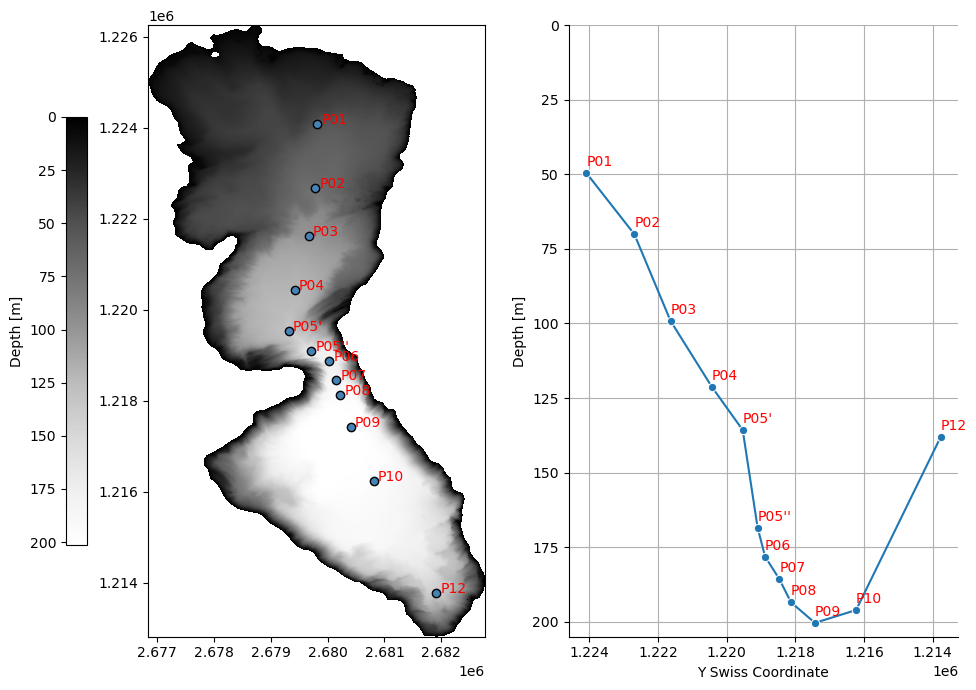

In [12]:
profile_locs, bathy = extract_profile_locations(dpath_L1)
plot_profiles_map_bathy(profile_locs, bathy)

In [22]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')
rho_data = extract_data_vars(dpath_L1, 'rho')
turb_data = extract_data_vars(dpath_L1, 'Turb')

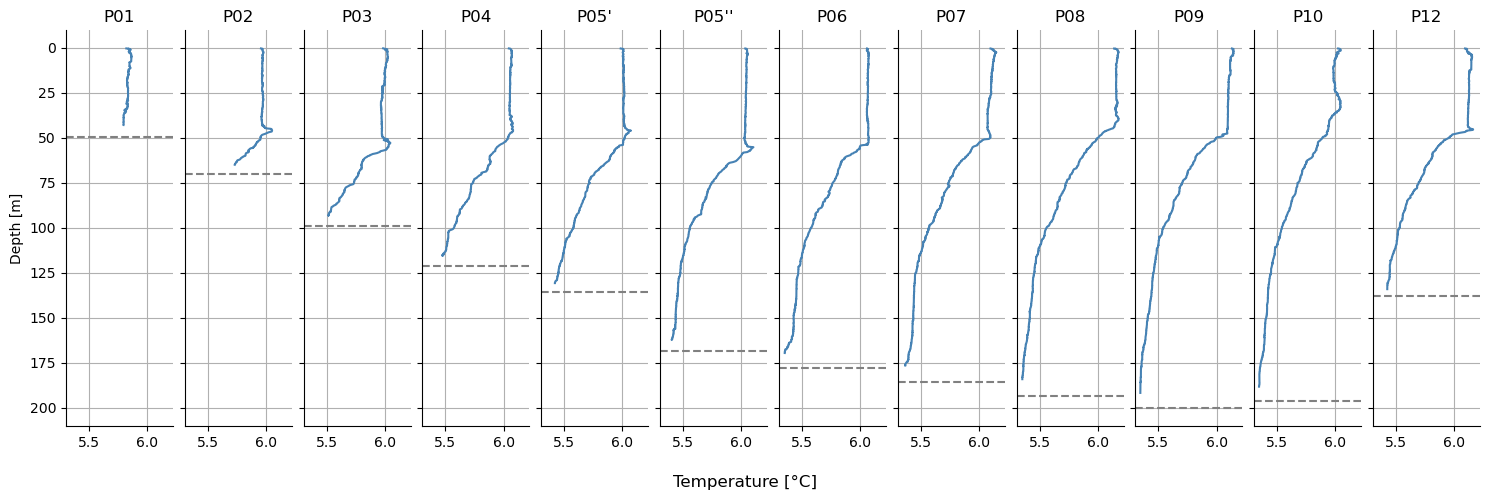

In [23]:
plot_profiles_transect(temp_data, 'Temp', '11:30')

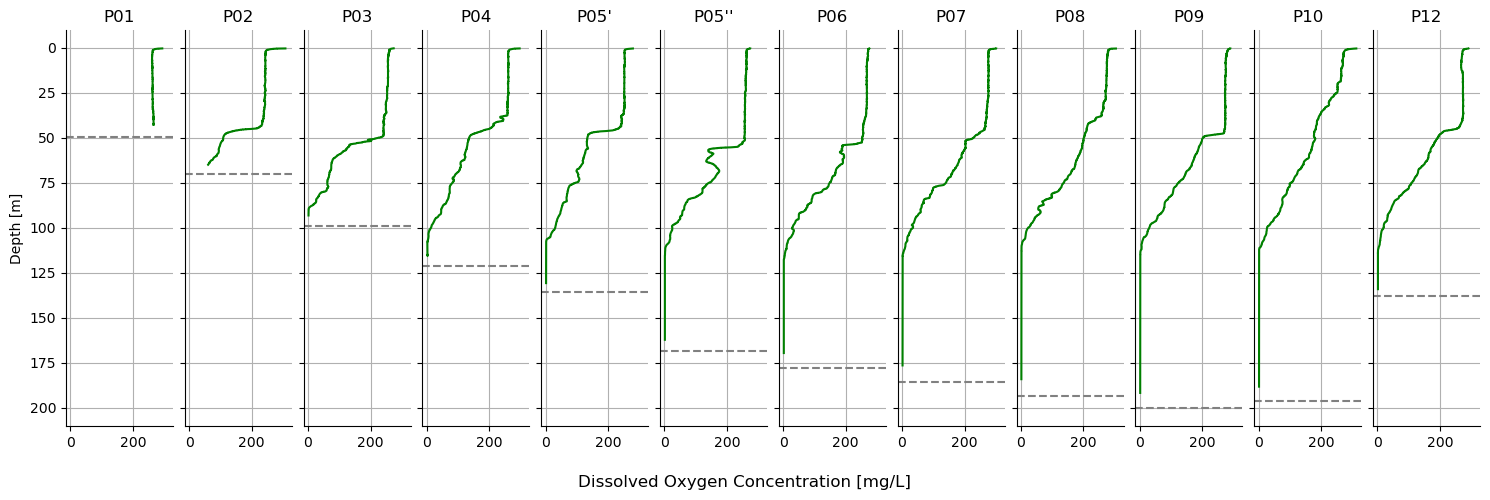

In [24]:
plot_profiles_transect(do_data, 'DO_mg', '11:30')

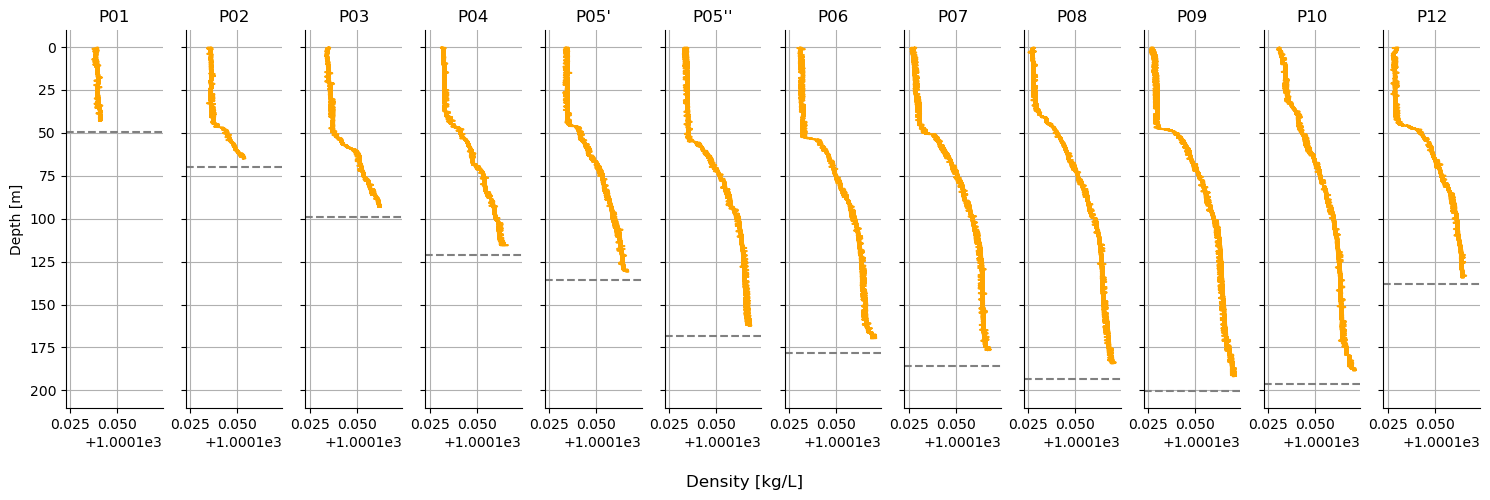

In [28]:
plot_profiles_transect(rho_data, 'rho', '11:30')

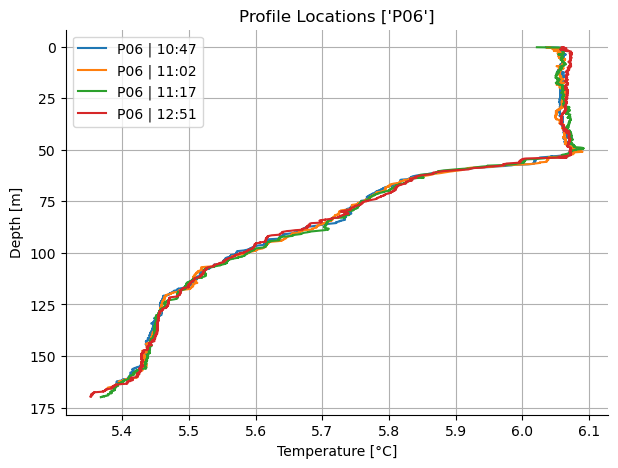

In [26]:
plot_profiles_overlay(temp_data, 'Temp', ['P06'])

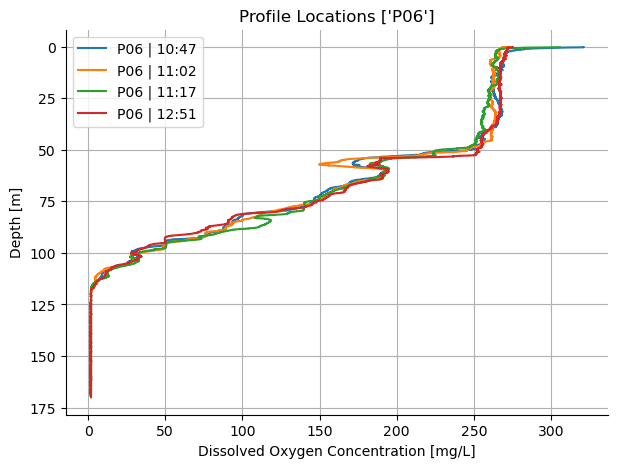

In [27]:
plot_profiles_overlay(do_data, 'DO_mg', ['P06'])

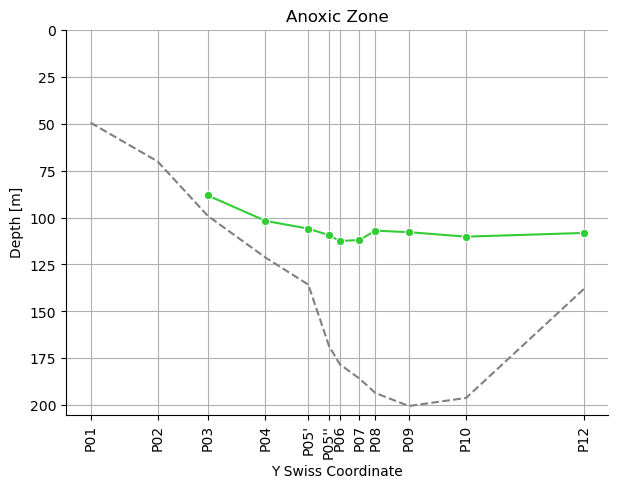

In [31]:
anoxic_data = calculate_anoxia(dpath_L1)
plot_anoxia(anoxic_data, t_start='11:30')

#### 01.12.2026

In [46]:
date = '20260112'
dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

In [47]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')
rho_data = extract_data_vars(dpath_L1, 'rho')

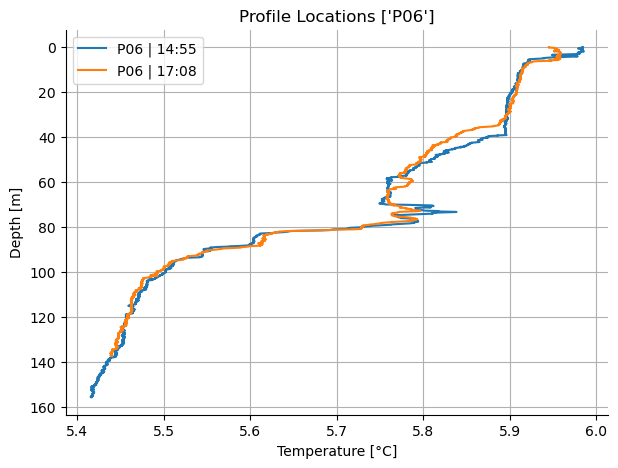

In [44]:
plot_profiles_overlay(temp_data, 'Temp', ["P06"])

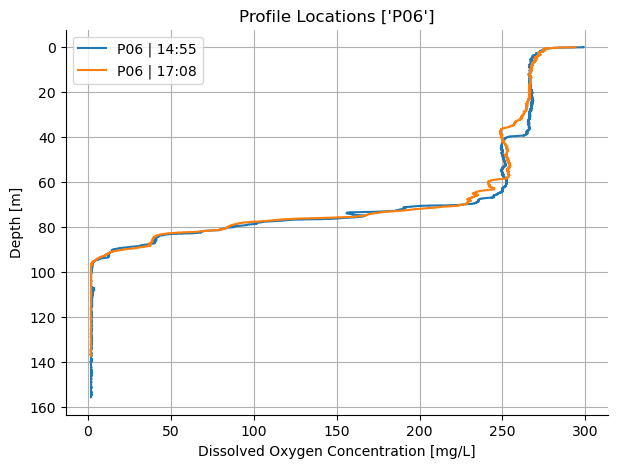

In [45]:
plot_profiles_overlay(do_data, 'DO_mg', ["P06"])

#### 01.13.2026

In [32]:
date = '20260113'
dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

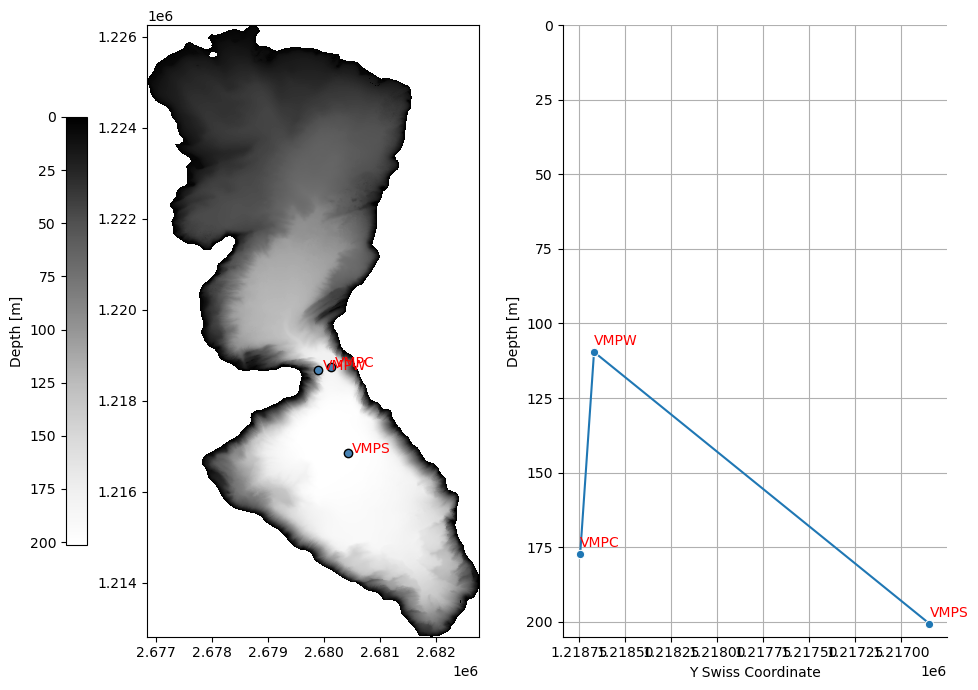

In [33]:
profile_locs, bathy = extract_profile_locations(dpath_L1)
plot_profiles_map_bathy(profile_locs, bathy)

In [34]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')

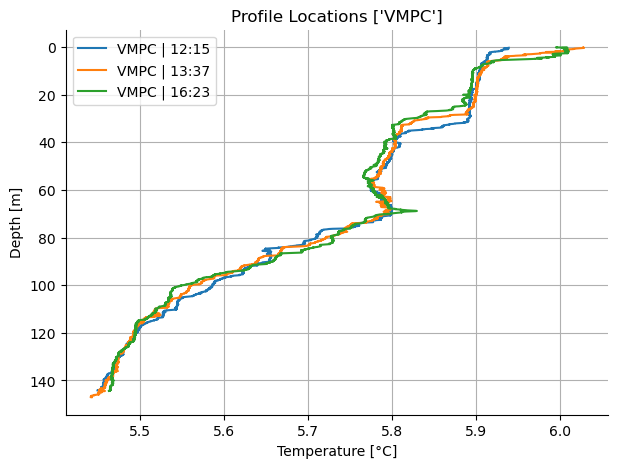

In [35]:
plot_profiles_overlay(temp_data, 'Temp', ["VMPC"])

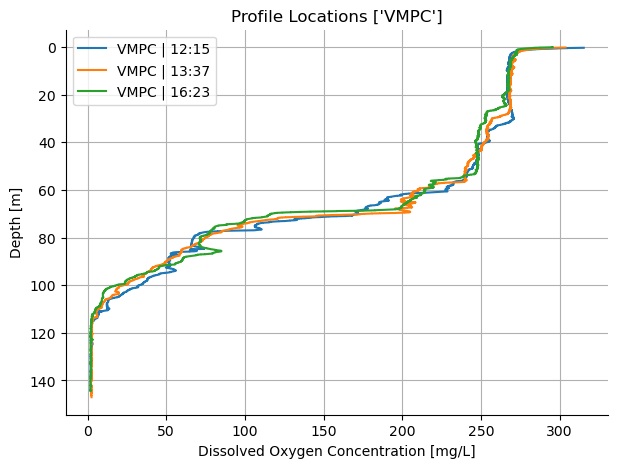

In [36]:
plot_profiles_overlay(do_data, 'DO_mg', ["VMPC"])

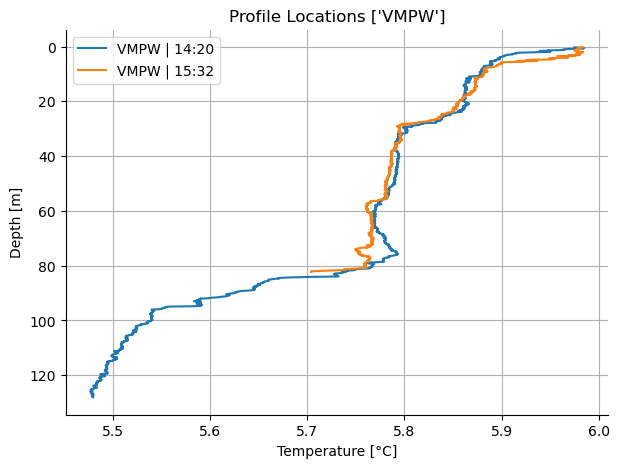

In [37]:
plot_profiles_overlay(temp_data, 'Temp', ["VMPW"])

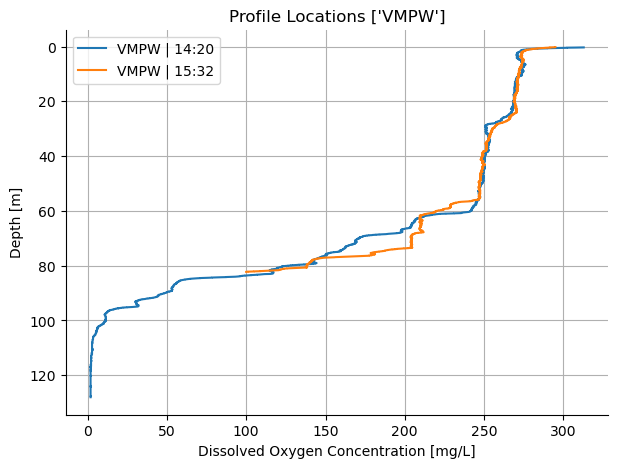

In [38]:
plot_profiles_overlay(do_data, 'DO_mg', ["VMPW"])

### Mooring

In [49]:
location = 'LZC'
date = '20260114'
t_start = '2025-11-01'
t_end = '2026-01-13'

In [50]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()
thermistors = mreader.get_thermistors()
oxygen_loggers = mreader.get_oxygen_loggers()

#### ADCPS

In [51]:
all_adcp = []
for adcp in adcps:
    serial_id = adcp['serial_id']

    areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
    fpath = areader.locate_data_file('L0')
    ds = areader.load_from_L0(fpath)
    ds = areader.range_to_depth(ds)
    ds = areader.run_qa(ds)
    print(areader.depth)
    ds = ds.sel(time=slice(t_start, t_end))
    all_adcp.append(ds)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\12U8315.000 ...
43.408226013183594

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U672.000 ...
71.59141540527344

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\6D1728.000 ...
80.0

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...
131.96441650390625


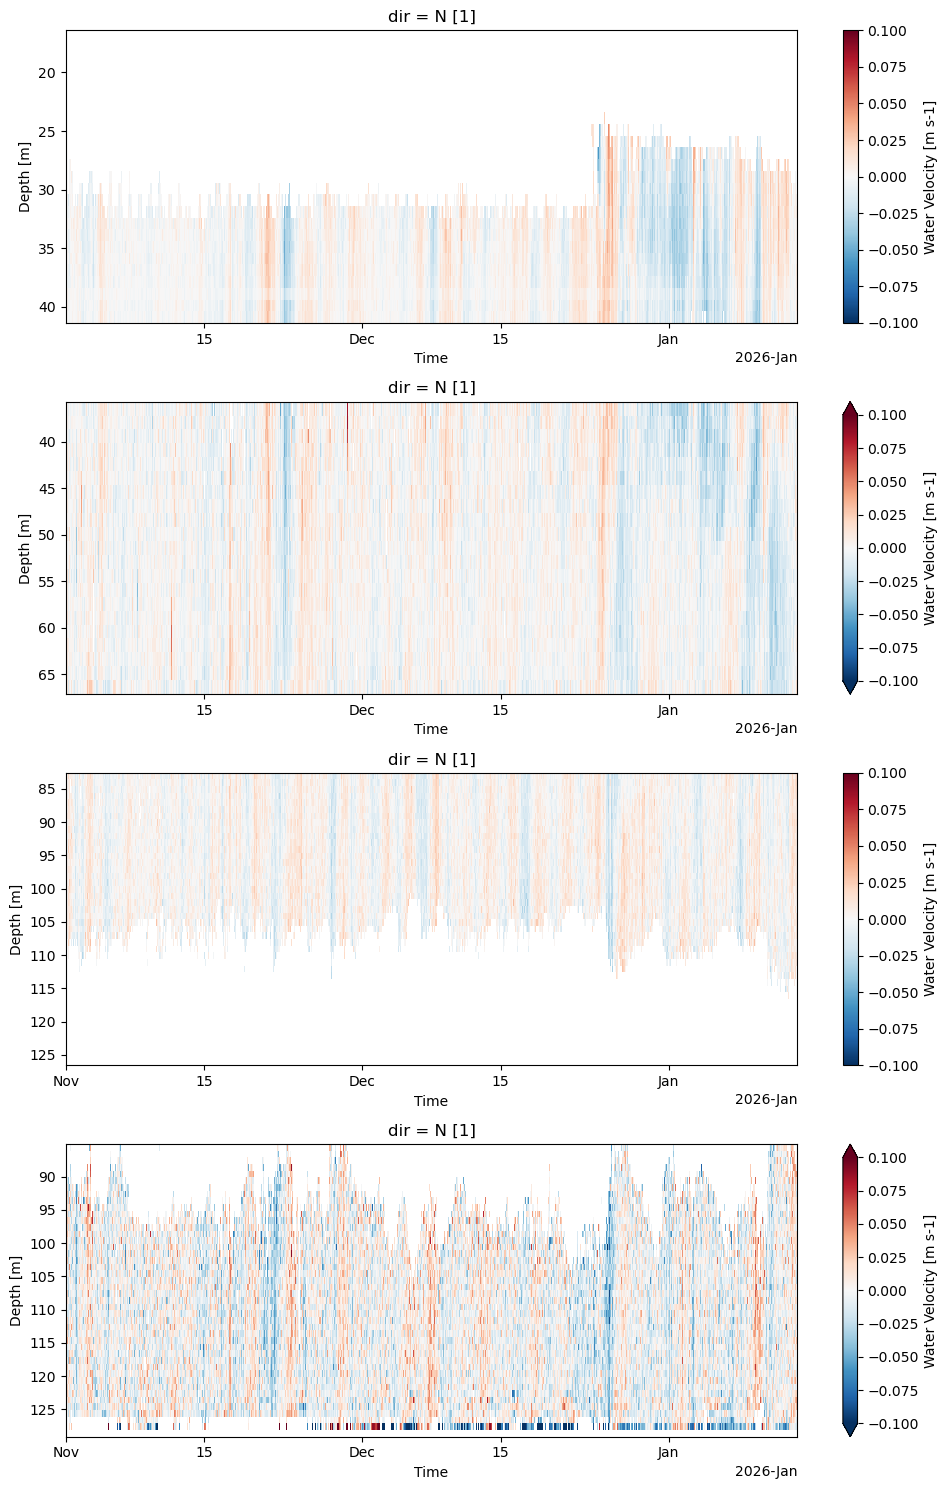

In [52]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

for i, d in enumerate(all_adcp):
    d.vel.sel(dir='N').plot(cmap='RdBu_r', vmin=-0.1, vmax=0.1, ax=ax[i])

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Depth [m]')

    ax[i].invert_yaxis()

plt.tight_layout()
plt.show()

#### Oxygen Loggers

In [58]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.fpath = fpath
    oreader.sensor = oreader.get_sensor_type()
    oreader.mab = oreader.get_mab()
    oreader.depth = oreader.set_depth()

    ds = oreader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(ds)

ds_do = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


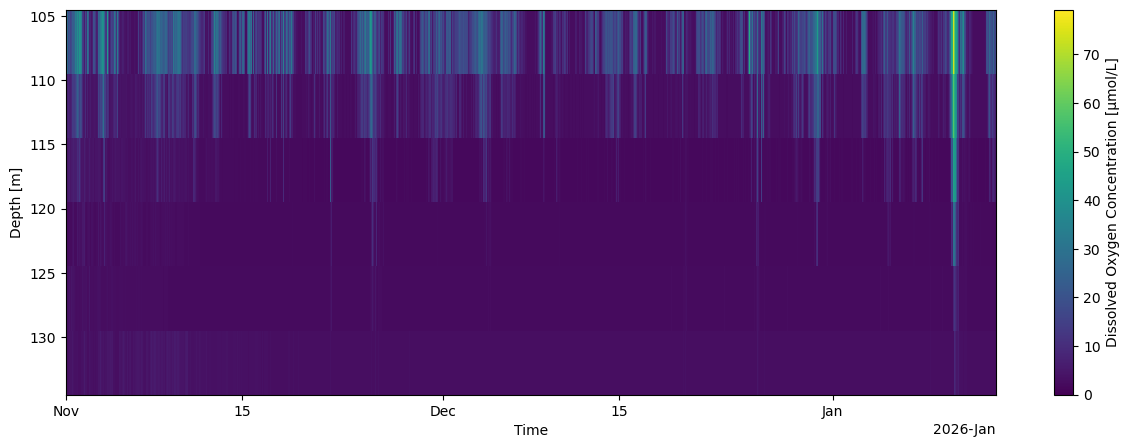

In [59]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_do.d_oxygen_conc.plot(cmap='viridis', vmin=0, ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Dissolved Oxygen Concentration [µmol/L]")

ax.invert_yaxis()
plt.show()

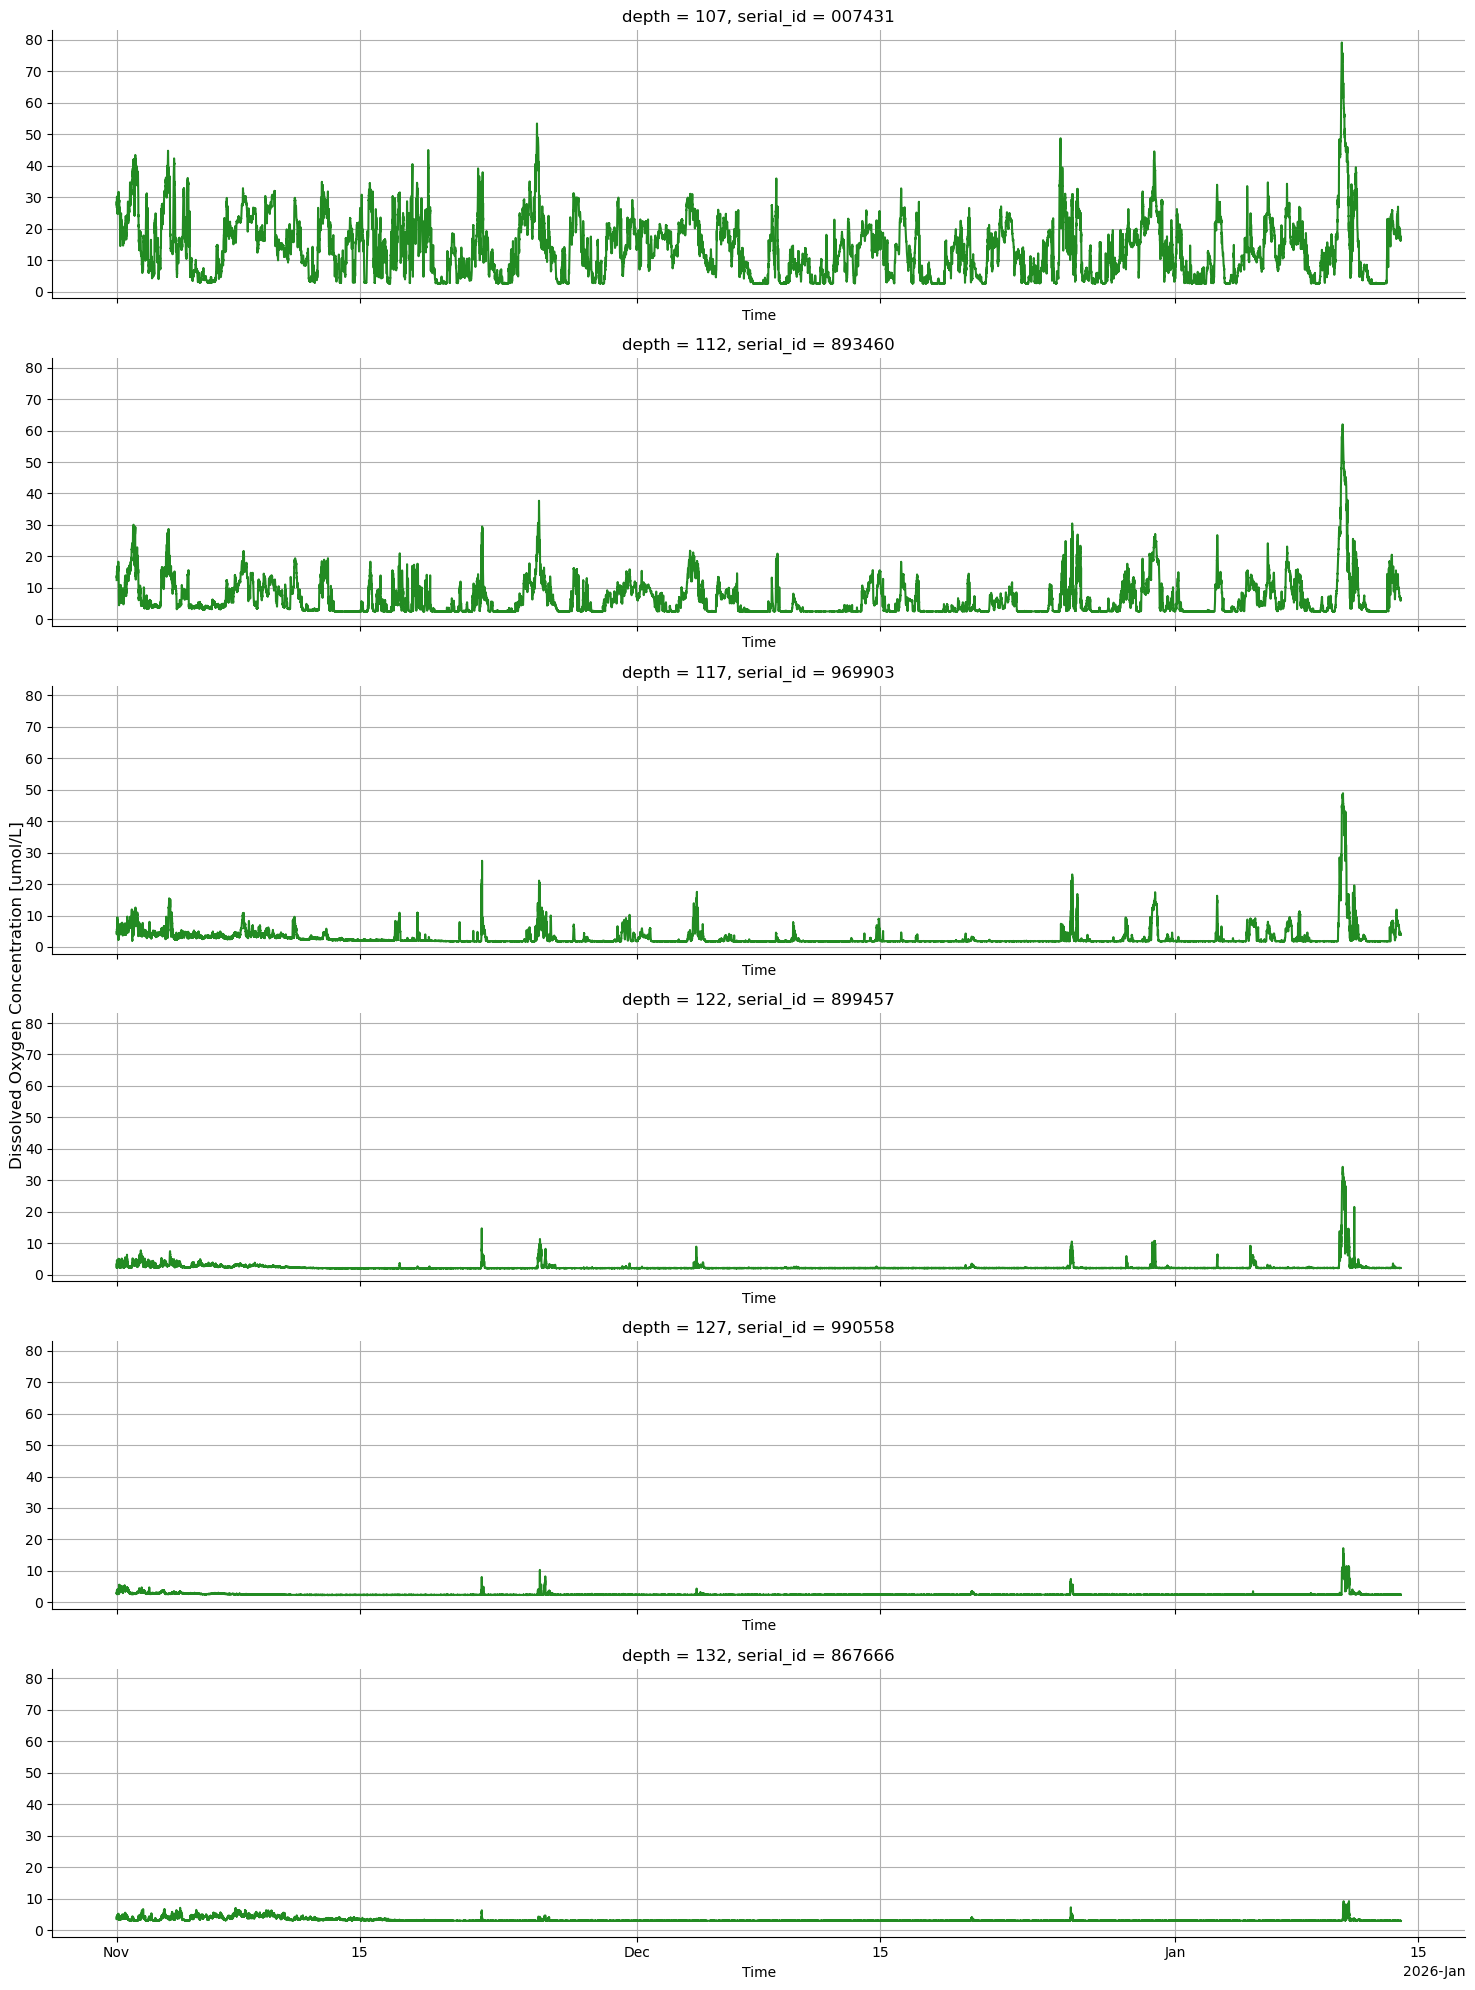

In [60]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 20), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['d_oxygen_conc'].plot(color='forestgreen', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Dissolved Oxygen Concentration [umol/L]')
plt.tight_layout()
plt.show()

In [68]:
ds_sel = ds_do.sel(depth=120, method='nearest')

In [77]:
time = ds_sel['time'].values
do_conc = ds_sel['d_oxygen_conc'].values

do_depth_t = []
toggle = False
for i, do in enumerate(do_conc):
    if do >= 10 and not toggle:
        do_depth_t.append(time[i])
        toggle = True
    elif do < 10 and toggle:
        toggle = False

do_depth_t

[np.datetime64('2025-11-22T00:42:00.000000000'),
 np.datetime64('2025-11-22T00:51:00.000000000'),
 np.datetime64('2025-11-22T01:04:00.000000000'),
 np.datetime64('2025-11-25T09:22:00.000000000'),
 np.datetime64('2025-12-26T01:01:00.000000000'),
 np.datetime64('2025-12-30T16:09:00.000000000'),
 np.datetime64('2025-12-30T19:19:00.000000000'),
 np.datetime64('2026-01-10T11:13:00.000000000'),
 np.datetime64('2026-01-10T12:16:00.000000000'),
 np.datetime64('2026-01-10T12:20:00.000000000'),
 np.datetime64('2026-01-10T12:27:00.000000000'),
 np.datetime64('2026-01-10T13:10:00.000000000'),
 np.datetime64('2026-01-10T13:40:00.000000000'),
 np.datetime64('2026-01-10T13:49:00.000000000'),
 np.datetime64('2026-01-10T19:01:00.000000000'),
 np.datetime64('2026-01-10T19:17:00.000000000'),
 np.datetime64('2026-01-10T19:28:00.000000000'),
 np.datetime64('2026-01-10T19:35:00.000000000'),
 np.datetime64('2026-01-10T20:07:00.000000000'),
 np.datetime64('2026-01-10T20:13:00.000000000'),
 np.datetime64('2026

#### Thermistors

In [61]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
    ds = treader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds_chain.append(ds)

ds_temp = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


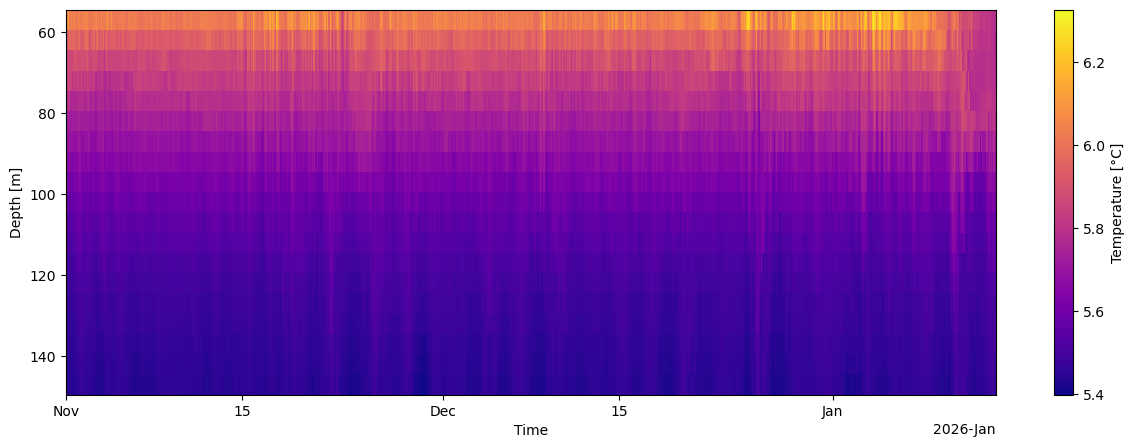

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_temp.temp.plot(cmap='plasma', ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Temperature [°C]")

ax.invert_yaxis()
plt.show()

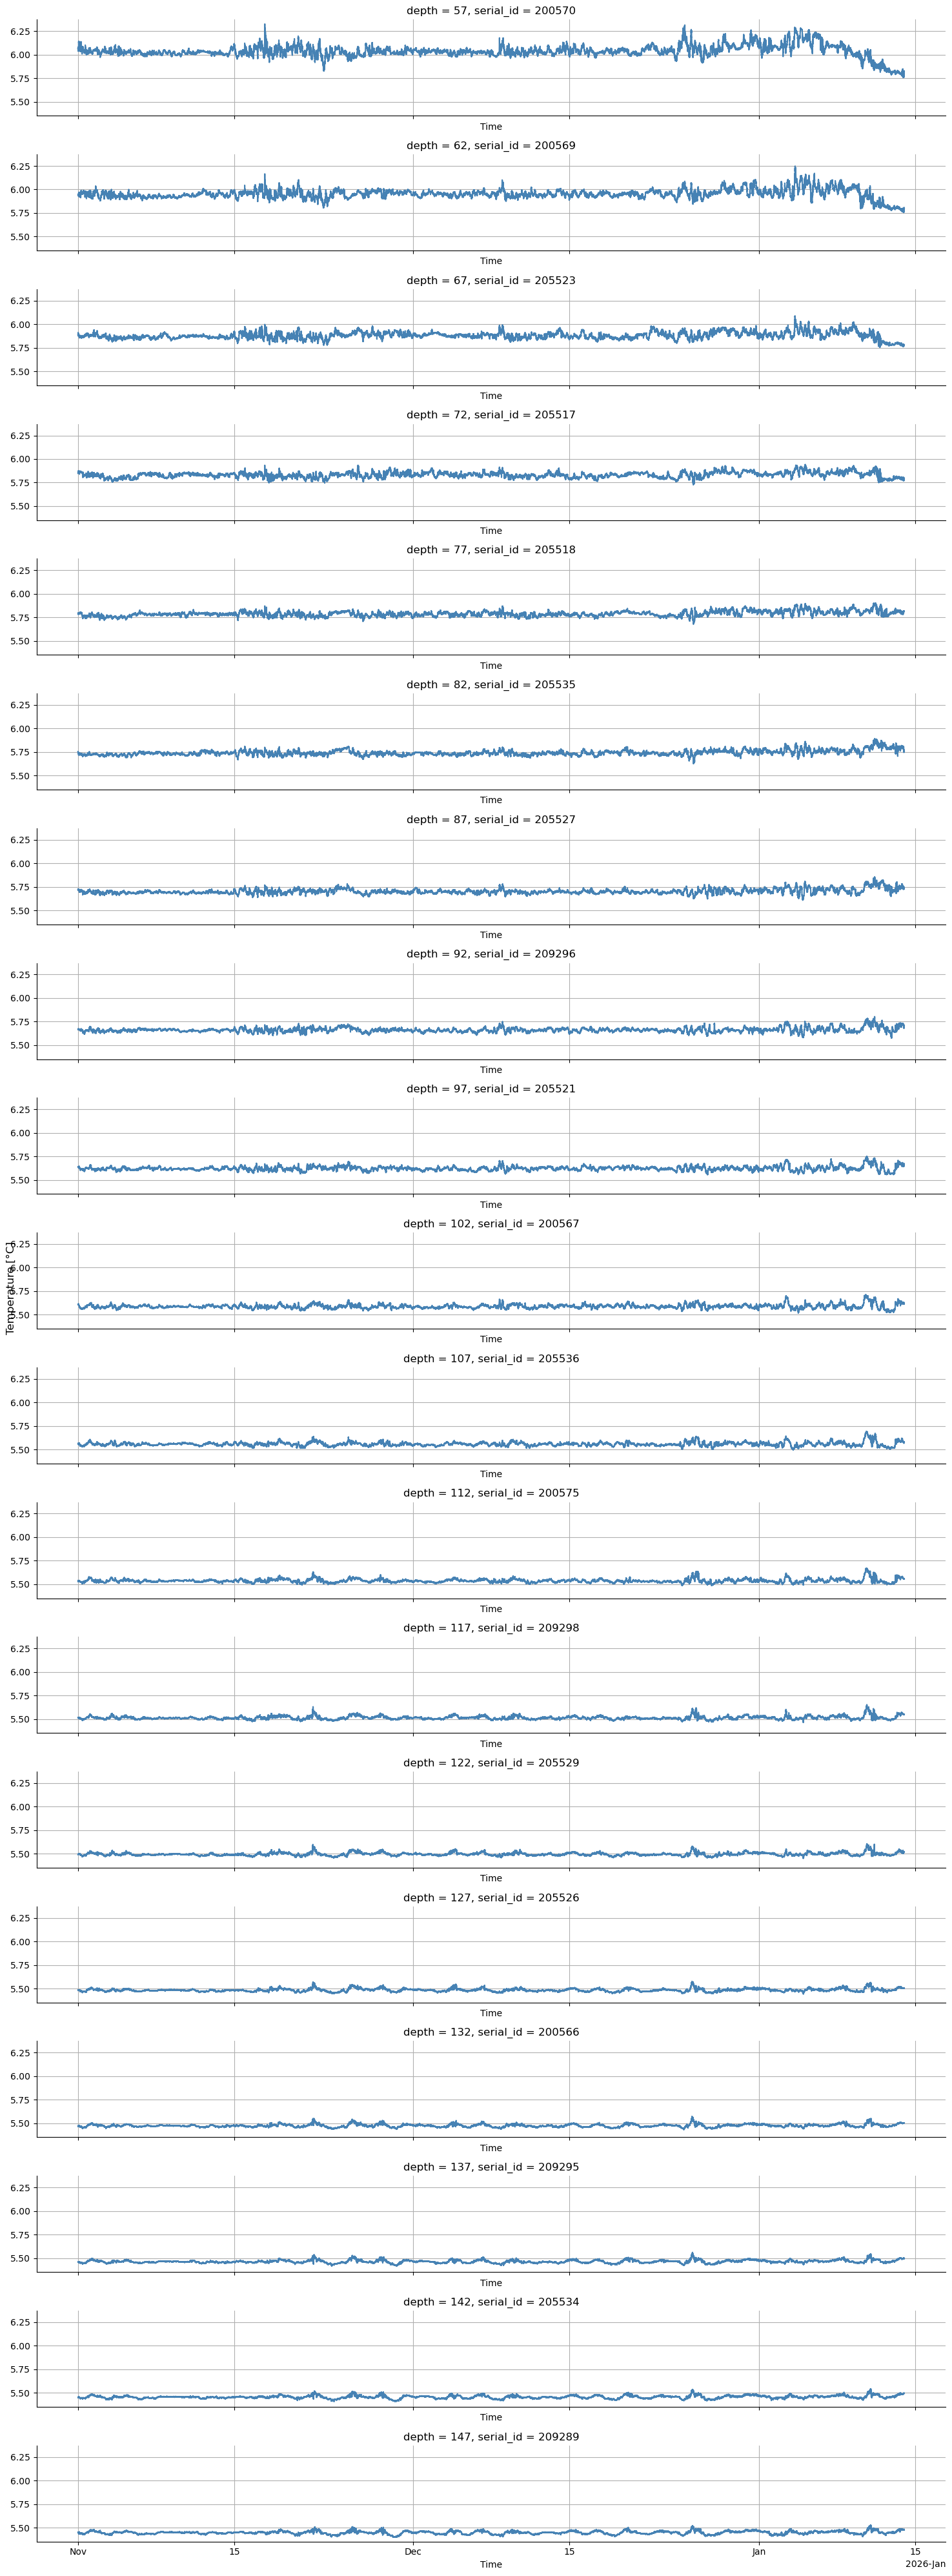

In [63]:
fig, ax = plt.subplots(nrows=len(thermistors), ncols=1, figsize=(15, 40), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['temp'].plot(color='steelblue', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Temperature [°C]')
plt.tight_layout()
plt.show()